In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder

In [3]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

In [4]:
# Preparing data for analysis
# This cell is a bit slow to run, so it is intended to be run only once

# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# Label encode non-numerical features

label_encoded_hotel_address = LabelEncoder()
data['Hotel_Address'] = label_encoded_hotel_address.fit_transform(data['Hotel_Address'])

label_encoded_hotel_name = LabelEncoder()
data['Hotel_Name'] = label_encoded_hotel_address.fit_transform(data['Hotel_Name'])

label_encoded_reviwer_nationality = LabelEncoder()
data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(data['Reviewer_Nationality'])

# # The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
# hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
# data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model

### Plot of correlation matrix in order to see which numerical features can be dropped.

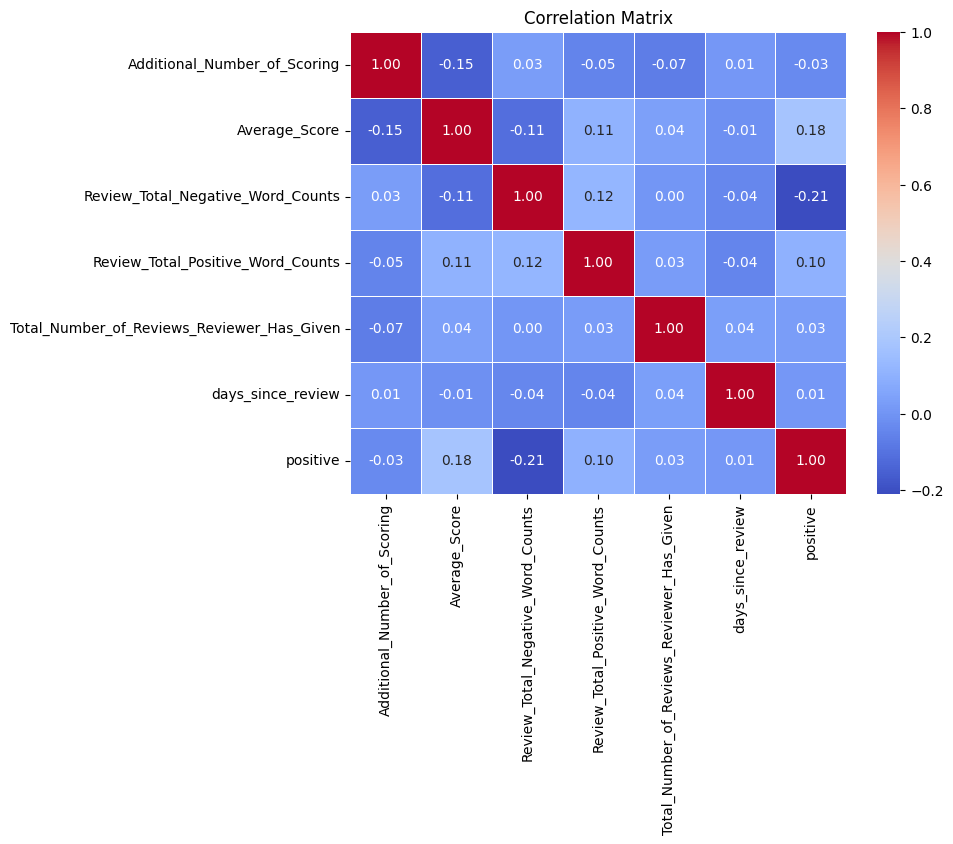

In [5]:
# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data['positive'] = (data['Reviewer_Score'] >= 5).astype(int)

numerical_and_le_data = data[['Hotel_Address', 'Hotel_Name','Additional_Number_of_Scoring', 'Average_Score', 'Review_Total_Negative_Word_Counts',
                            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                            'days_since_review', 'lat', 'lng', 'positive']]

numerical_data = data[['Additional_Number_of_Scoring', 'Average_Score', 'Review_Total_Negative_Word_Counts',
                            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                            'days_since_review', 'positive']]

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap (ChatGPT)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment. 

In [6]:
# Dropping irrelevant features
data.drop('Hotel_Address',axis=1,inplace=True)  
data.drop('Hotel_Name',axis=1,inplace=True)  
data.drop('Review_Date',axis=1,inplace=True)    
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  
data.drop('lat',axis=1,inplace=True)    
data.drop('lng',axis=1,inplace=True)    
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)   
data.drop('Total_Number_of_Reviews_Reviewer_Has_Given',axis=1,inplace=True)
data.drop('days_since_review',axis=1,inplace=True)  
data.drop('Reviewer_Nationality',axis=1,inplace=True)  

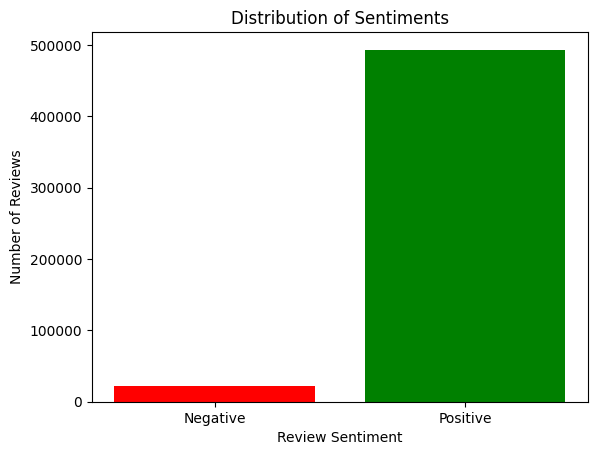

Counter({1: 493457, 0: 22281})


In [7]:
# Used for plotting the amount of positive and negative reviews

# convert reviewer score to binary labels (positive or negative review)
sentiment = (data['Reviewer_Score'] >= 5).astype(int)

positive_count = np.sum(sentiment == 1)
negative_count = np.sum(sentiment == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments")

plt.show()
print(Counter(data['positive'])) # finding ratio of positive to negative reviews

### Dealing with the imbalance

#### The issue
When setting the threshold at 5, we get an extremely umbalanced target variable. ~95% of reviews have a reviewer score of 5 or higher. This means that the models can achieve 95% accuracy by guessing that every review is positive.

#### Methods
There are multiple ways of dealing with imbalance. The most common methods are
- Resampling (over/undersampling)
    - Oversampling: Include more of the minority class
        - Might cause overfitting
    - Undersampling: Include less of the majority class
        - Lower risk of overfitting, but information is lost
- Class weights
    - Assign a weight to the classes that punishes predicting negative reviews as positive
    - Good for binary classification
- Focal loss
    - Focuses learning on the minority class
- Stratification
    - Ensures the ratio of positive and negative reviews remains constant when splitting the dataset